In [23]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle


def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus),
                  "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


solve_cudnn_error()

# %matplotlib inline
# def W_init(shape, dtype=None):
#     """Initialize weights as in paper"""
#     values = rng.normal(loc=0, scale=1e-2, size=shape)
#     return K.variable(values, dtype=dtype)

# #//TODO: figure out how to initialize layer biases in keras.
# def b_init(shape, dtype=None):
#     """Initialize bias as in paper"""
#     values = rng.normal(loc=0.5, scale=1e-2, size=shape)
#     return K.variable(values, dtype=dtype)

input_shape = (96, 96,1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(
    Conv2D(64, (10, 10),
           activation='relu',
           input_shape=input_shape,
           kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128, (7, 7), activation='relu',
                   kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128, (4, 4), activation='relu',
                   kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256, (4, 4), activation='relu',
                   kernel_regularizer=l2(2e-4))),
convnet.add(Flatten())
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(0.001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)

siamese_net.count_params()

1 Physical GPUs, 1 Logical GPUs


17980225

In [24]:
convnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 87, 87, 64)        6464      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 37, 37, 128)       401536    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)       262272    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 256)        

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [25]:
PATH = "../../../data_set/模型訓練資料/save/"  #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "x_train.pickle"), "rb") as f:
    (X, c, l) = pickle.load(f)
    
with open(os.path.join(PATH, "x_val.pickle"), "rb") as f:
    (Xval, cval, lval) = pickle.load(f)

print("training alphabets")
print(c)

training alphabets
{0: ['丁'], 1: ['三'], 2: ['上'], 3: ['不'], 4: ['世'], 5: ['丞'], 6: ['中'], 7: ['主'], 8: ['久'], 9: ['之'], 10: ['事'], 11: ['于'], 12: ['五'], 13: ['亞'], 14: ['交'], 15: ['亨'], 16: ['京'], 17: ['亮'], 18: ['人'], 19: ['仁'], 20: ['介'], 21: ['仕'], 22: ['仙'], 23: ['代'], 24: ['仲'], 25: ['任'], 26: ['份'], 27: ['企'], 28: ['伊'], 29: ['伍'], 30: ['伯'], 31: ['伶'], 32: ['位'], 33: ['佑'], 34: ['何'], 35: ['余'], 36: ['作'], 37: ['佩'], 38: ['佳'], 39: ['來'], 40: ['侑'], 41: ['侯'], 42: ['俊'], 43: ['保'], 44: ['信'], 45: ['修'], 46: ['倉'], 47: ['倫'], 48: ['偉'], 49: ['健'], 50: ['傅'], 51: ['傑'], 52: ['備'], 53: ['傳'], 54: ['僑'], 55: ['儀'], 56: ['億'], 57: ['儒'], 58: ['優'], 59: ['允'], 60: ['元'], 61: ['兆'], 62: ['先'], 63: ['光'], 64: ['克'], 65: ['兒'], 66: ['內'], 67: ['全'], 68: ['公'], 69: ['其'], 70: ['具'], 71: ['典'], 72: ['冠'], 73: ['冷'], 74: ['凌'], 75: ['凍'], 76: ['凱'], 77: ['分'], 78: ['利'], 79: ['刷'], 80: ['券'], 81: ['創'], 82: ['劉'], 83: ['力'], 84: ['加'], 85: ['助'], 86: ['勁'], 87: ['勇'], 88: ['動'], 89: ['務'], 

In [34]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets=["train", "val"]):
        self.data = {}
        self.label = {}
        self.categories = {}
        self.lang_dict = {}
        self.info = {}
        self.n_class = 0
        # loading the data
        for name in data_subsets:
            file_path = os.path.join(path, "x_" + name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path, "rb") as f:
                (X, c, l) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c
                self.lang_dict[name] = l
        # loading the label
        for name in data_subsets:
            file_path = os.path.join(path, "y_" + name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path, "rb") as f:
                y = pickle.load(f)
                self.label[name] = y

    def get_batch(self, batch_size, s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X = self.data[s]
        y = self.label[s]
        l = self.lang_dict[s]
        c = self.categories[s]
        all_samples, w, h = X.shape
        n_classes = len(c)
        #randomly sample several classes to use in the batch
        categories_temp = rng.choice(n_classes,
                                     size=(batch_size, ),
                                     replace=False)
        #initialize 2 empty arrays for the input image batch

        #pairs=[np.zeros((batch_size, w, h,chanel)) for i in range(2)]
        pairs0 = []
        pairs1 = []
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size, ))
        targets[batch_size // 2:] = 1
        for i in range(batch_size):
            category = categories_temp[i]
            # find the num of examples of the class
            idx_1 = rng.randint(l[c[category][0]][0], l[c[category][0]][1])
            pairs0.append(X[idx_1])
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category
            else:
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = rng.randint(n_classes)

            idx_2 = rng.randint(l[c[category_2][0]][0], l[c[category_2][0]][1])
            pairs1.append(X[idx_2])

        pairs0 = np.stack(pairs0)
        pairs1 = np.stack(pairs1)
        pairs = [pairs0, pairs1]
        return pairs, targets

    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield (pairs, targets)

    def make_oneshot_task(self, N, s="val", words=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X = self.data[s]
        y = self.label[s]
        l = self.lang_dict[s]
        c = self.categories[s]
        all_samples, w, h = X.shape

        if s == 'val':
            n_classes_low = list(loader.categories['val'].keys())[0]
            n_classes_high = list(loader.categories['val'].keys())[-1]
        else:
            n_classes = len(c)

        #indices = rng.randint(0,n_examples,size=(N,))
        if words is not None:
            low, high = l[words]
            if N > high - low:
                raise ValueError(
                    "This language ({}) has less than {} letters".format(
                        words, N))
            categories = rng.choice(range(low, high), size=(N, ))

        else:  #if no language specified just pick a bunch of random letters
            if s == 'val':
                categories = rng.choice(range(n_classes_low, n_classes_high),
                                        size=(N, ),
                                        replace=False)
            else:
                categories = rng.choice(range(n_classes),
                                        size=(N, ),
                                        replace=False)
        true_category = categories[0]
        ex1 = rng.randint(l[c[true_category][0]][0], l[c[true_category][0]][1])
        ex2 = rng.randint(l[c[true_category][0]][0], l[c[true_category][0]][1])
        test_image = np.asarray([X[ex1]] * N).reshape(N, w, h)

        # build the support set
        support_set = []
        for category in categories:
            idx = rng.randint(l[c[category][0]][0], l[c[category][0]][1])
            support_set.append(X[idx])
        support_set = np.stack(support_set)
        support_set[0] = X[ex2]
        #        support_set = support_set.reshape(N, w, h,3)
        targets = np.zeros((N, ))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image,
                                                   support_set)
        pairs = [test_image, support_set]

        return pairs, targets

    def test_oneshot(self, model, N, k, s="val", verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print(
                "Evaluating model on {} random {} way one-shot learning tasks ..."
                .format(k, N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N, s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".
                  format(percent_correct, N))
        return percent_correct

    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size), )


#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from ../../../data_set/模型訓練資料/save/x_train.pickle
loading data from ../../../data_set/模型訓練資料/save/x_val.pickle
loading data from ../../../data_set/模型訓練資料/save/y_train.pickle
loading data from ../../../data_set/模型訓練資料/save/y_val.pickle


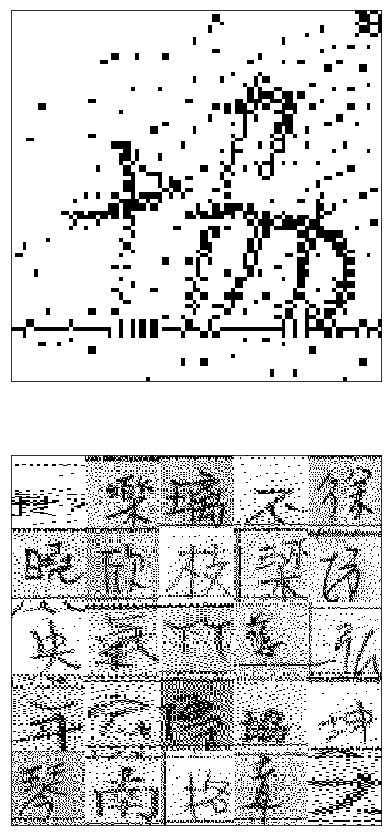

In [35]:
# i just concat the images into same shape in the data loader
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    N, h, w = X.shape
    X = X.reshape(N, h, w)
    n = int(np.ceil(np.sqrt(N)))
    img = np.zeros((n * w, n * h))
    x = 0
    y = 0
    for example in range(N):
        img[x * w:(x + 1) * w, y * h:(y + 1) * h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
    ax1.matshow(pairs[0][0], cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img.astype('uint8'), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(25, "train")
plot_oneshot_task(pairs)

In [39]:
#Training loop
print("!")
evaluate_every = 1  # interval for evaluating on one-shot tasks
loss_every = 50  # interval for printing loss (iterations)
batch_size = 16
n_iter = 100
N_way = 4  # how many classes for testing one-shot tasks>
n_val = 10  #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs, targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net, N_way, n_val, verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best = val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i, loss))

!
training
0.7109616994857788
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 10.0% 4 way one-shot learning accuracy
saving
INFO:tensorflow:Assets written to: ../../../data_set/模型訓練資料/save/weights\assets
0.7105136513710022
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 30.0% 4 way one-shot learning accuracy
saving
INFO:tensorflow:Assets written to: ../../../data_set/模型訓練資料/save/weights\assets
0.7091463804244995
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 30.0% 4 way one-shot learning accuracy
saving
INFO:tensorflow:Assets written to: ../../../data_set/模型訓練資料/save/weights\assets
0.7084941267967224
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 40.0% 4 way one-shot learning accuracy
saving
INFO:tensorflow:Assets written to: ../../../data_set/模型訓練資料/save/weights\assets
0.7096141576766968
evaluating
Evaluat

INFO:tensorflow:Assets written to: ../../../data_set/模型訓練資料/save/weights\assets
0.6980685591697693
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 20.0% 4 way one-shot learning accuracy
0.7062687277793884
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 20.0% 4 way one-shot learning accuracy
iteration 50, training loss: 0.71,
0.7180928587913513
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 10.0% 4 way one-shot learning accuracy
0.7009385228157043
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 40.0% 4 way one-shot learning accuracy
0.6996724009513855
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 20.0% 4 way one-shot learning accuracy
0.7023197412490845
evaluating
Evaluating model on 10 random 4 way one-shot learning tasks ...
Got an average of 60.0% 4 way one-sh

Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 1 way one-shot learning tasks ...
Evaluating model on 5 random 6 way one-shot learning tasks ...


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Got an average of 0.0% 6 way one-shot learning accuracy
Evaluating model on 5 random 6 way one-shot learning tasks ...
Got an average of 0.0% 6 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 6 way one-shot learning tasks ...
Evaluating model on 5 random 11 way one-shot learning tasks ...
Got an average of 0.0% 11 way one-shot learning accuracy
Evaluating model on 5 random 11 way one-shot learning tasks ...
Got an average of 0.0% 11 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 11 way one-shot learning tasks ...
Evaluating model on 5 random 16 way one-shot learning tasks ...
Got an average of 0.0% 16 way one-shot learning accuracy
Evaluating model on 5 random 16 way one-shot learning tasks ...
Got an average of 0.0% 16 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 16 way one-shot learning tasks ...
Evaluating model on 5 random 21 way one-shot learning tasks ...
Got an average of 0.0% 21 way one-shot learning ac

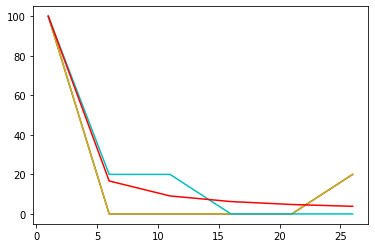

In [37]:
def nearest_neighbour_correct(pairs, targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways, n_trials, loader):
    """Returns accuracy of one shot """
    print(
        "Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ..."
        .format(n_trials, N_ways))

    n_right = 0

    for i in range(n_trials):
        pairs, targets = loader.make_oneshot_task(N_ways, "val")
        correct = nearest_neighbour_correct(pairs, targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 5)
resume = False
val_accs, train_accs, nn_accs = [], [], []
trials = 5
for N in ways:
    val_accs.append(
        loader.test_oneshot(siamese_net, N, trials, "val", verbose=True))
    train_accs.append(
        loader.test_oneshot(siamese_net, N, trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N, trials, loader))

#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways, 100.0 / ways, "r")
plt.show()

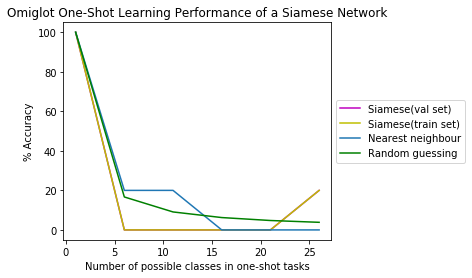

(20, 96, 96)


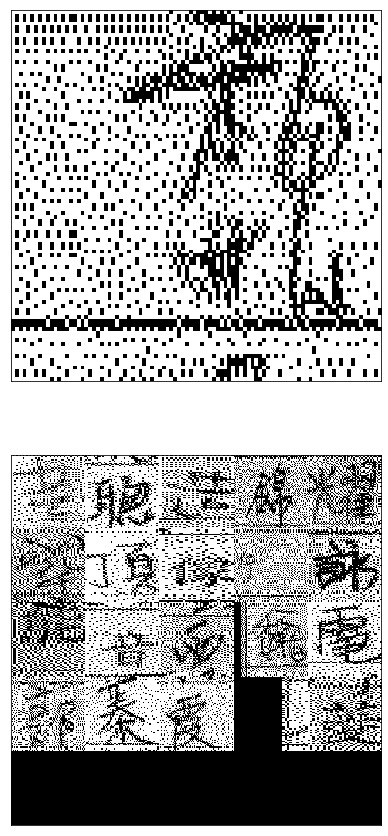

[[0.5009294 ]
 [0.49474376]
 [0.50272644]
 [0.4995147 ]
 [0.4986636 ]
 [0.5010131 ]
 [0.50084263]
 [0.49912393]
 [0.50188714]
 [0.4929196 ]
 [0.49952158]
 [0.4989344 ]
 [0.49777406]
 [0.50241494]
 [0.49891838]
 [0.5011491 ]
 [0.5016635 ]
 [0.5018456 ]
 [0.49713993]
 [0.5006213 ]]


In [38]:
fig, ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0 / ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs, targets = loader.make_oneshot_task(20, "val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p = siamese_net.predict(inputs)
print(p)

In [20]:
np.argmax(p)

6